In [ ]:
pip install -r requirements.txt

In [1]:
import polars as pl
import os
print(os.getcwd())

c:\Users\eliot.nehme\repositories\memoire-ia\codes


In [6]:
# On définit explicitement que DEPT est du texte
table_souscription = pl.read_csv("Donnes_souscription.csv")

print(table_souscription)

ComputeError: could not parse `"2B"` as dtype `i64` at column 'DEPT' (column number 6)

The current offset in the file is 16420 bytes.

You might want to try:
- increasing `infer_schema_length` (e.g. `infer_schema_length=10000`),
- specifying correct dtype with the `schema_overrides` argument
- setting `ignore_errors` to `True`,
- adding `"2B"` to the `null_values` list.

Original error: ```invalid primitive value found during CSV parsing```

In [17]:
# avant de décider du type de chaque colonne. 
# C'est un peu plus lent (quelques secondes), mais c'est 100% sûr.

table_souscription = pl.read_csv(
    "../data/Donnees_souscription.csv", 
    infer_schema_length=None  # <--- Le secret est là !
)

print(f"Dimensions : {table_souscription.shape}") # Affiche le nombre de lignes/colonnes
print(table_souscription.head())

Dimensions : (108653, 27)
shape: (5, 27)
┌─────┬─────────────────┬───────────────────┬─────────────────┬───┬─────┬─────┬─────┬─────┐
│     ┆ num_police      ┆ date_debut_police ┆ date_fin_police ┆ … ┆ 2   ┆ 3   ┆ 4   ┆ 5   │
│ --- ┆ ---             ┆ ---               ┆ ---             ┆   ┆ --- ┆ --- ┆ --- ┆ --- │
│ i64 ┆ i64             ┆ str               ┆ str             ┆   ┆ f64 ┆ f64 ┆ f64 ┆ i64 │
╞═════╪═════════════════╪═══════════════════╪═════════════════╪═══╪═════╪═════╪═════╪═════╡
│ 2   ┆ 201000000000002 ┆ 2010-08-26        ┆ 2011-08-26      ┆ … ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0   │
│ 8   ┆ 201000000000008 ┆ 2010-03-22        ┆ 2011-03-22      ┆ … ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0   │
│ 54  ┆ 201000000000054 ┆ 2010-07-06        ┆ 2011-07-06      ┆ … ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0   │
│ 56  ┆ 201000000000056 ┆ 2010-05-13        ┆ 2011-05-13      ┆ … ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0   │
│ 71  ┆ 201000000000071 ┆ 2010-02-24        ┆ 2011-02-24      ┆ … ┆ 0.0 ┆ 0.0 ┆ 0.0 ┆ 0   │
└─────┴─────────────────┴──────────────

In [27]:
import numpy as np
import pandas as pd

In [34]:
df = pd.read_csv('../data/Donnees_souscription.csv')
print(df.head())

   Unnamed: 0       num_police date_debut_police date_fin_police  REGION DEPT  \
0           2  201000000000002        2010-08-26      2011-08-26      52   72   
1           8  201000000000008        2010-03-22      2011-03-22      11   77   
2          54  201000000000054        2010-07-06      2011-07-06      52   85   
3          56  201000000000056        2010-05-13      2011-05-13      76   66   
4          71  201000000000071        2010-02-24      2011-02-24      75   79   

  COMMUNE     CRITAIR                       ENERGIE  AGE_VOIT  ... TRANS GARL  \
0   72341  Crit'air 3                       Essence        10  ...     5    1   
1   77235  Crit'air 2                        Gazole         5  ...     6    1   
2   85226  Crit'air 1  Essence hybride rechargeable         0  ...     5    2   
3   66190  Crit'air 3                       Essence        16  ...     Z    2   
4   79249  Crit'air 2                        Gazole        16  ...     5    1   

   N_COND  ANCIENNETE  N_S

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import random
import os

# Chargement de la base de données
# J'utilise le chemin vers ton fichier CSV
df = pd.read_csv('../data/Donnees_souscription.csv')

# --- ÉTAPE 1 : Filtrer et Exploser la base ---

# On ne garde que les lignes ayant au moins 1 sinistre
# Note : la colonne dans le CSV est "N_SINISTRE" (singulier)
table_sinistres = df[df['N_SINISTRE'] > 0].copy()

# On "explose" la table : on duplique les lignes selon la valeur de N_SINISTRE
# Si N_SINISTRE = 2, la ligne est répétée 2 fois
table_sinistres = table_sinistres.loc[table_sinistres.index.repeat(table_sinistres['N_SINISTRE'])].reset_index(drop=True)

print(f"Nombre de lignes après explosion (doit correspondre au nombre total de sinistres) : {len(table_sinistres)}")

# --- ÉTAPE 2 : Simulation Actuarielle ---

# Conversion des colonnes dates en format datetime si ce n'est pas déjà fait
table_sinistres['date_debut_police'] = pd.to_datetime(table_sinistres['date_debut_police'])
table_sinistres['date_fin_police'] = pd.to_datetime(table_sinistres['date_fin_police'])

# 1. Simulation du COUT_SINISTRE (Loi Log-Normale)
# Paramètres de la loi normale sous-jacente (mu et sigma)
# Ces valeurs (mu=7, sigma=1.5) sont des exemples standards pour obtenir des montants réalistes.
# Tu peux les ajuster selon la sévérité moyenne désirée.
mu = 7.0
sigma = 1.5

# Génération des coûts aléatoires
table_sinistres['COUT_SINISTRE'] = np.random.lognormal(mean=mu, sigma=sigma, size=len(table_sinistres))

# Arrondi à 2 décimales pour faire "monétaire"
table_sinistres['COUT_SINISTRE'] = table_sinistres['COUT_SINISTRE'].round(2)

# 2. Simulation de la DATE_SINISTRE (Aléatoire entre date_debut et date_fin)
# Calcul de la durée de couverture en jours pour chaque ligne
duree_couverture = (table_sinistres['date_fin_police'] - table_sinistres['date_debut_police']).dt.days

# Génération d'un nombre de jours aléatoire entre 0 et la durée de couverture
jours_aleatoires = np.random.randint(0, duree_couverture + 1, size=len(table_sinistres))

# Ajout de ces jours à la date de début pour obtenir la date du sinistre
table_sinistres['DATE_SINISTRE'] = table_sinistres['date_debut_police'] + pd.to_timedelta(jours_aleatoires, unit='D')

# --- Affichage et Vérification ---
print("\n--- Aperçu de la nouvelle table table_sinistres ---")
print(table_sinistres[['num_police', 'N_SINISTRE', 'date_debut_police', 'DATE_SINISTRE', 'COUT_SINISTRE']].head(100))

# Sauvegarde optionnelle
# table_sinistres.to_csv('data/table_sinistres_generee.csv', index=False)





# --- ÉTAPE 3 : Injection de la Fraude et Association des Images ---

# 1. Définition des chemins vers tes images (Ceux de ton projet TER)
# J'ai repris les chemins de ton PDF, vérifie qu'ils sont toujours bons sur ton PC !
path_true_images = "../data/True_data"
path_fake_images = "../data/Fake_data"

# Petite sécurité : on vérifie si les dossiers existent, sinon on met un message
if not os.path.exists(path_true_images):
    print(f"ATTENTION : Le dossier {path_true_images} est introuvable. Vérifie le chemin.")
    images_reelles_dispo = []
else:
    # On liste tous les fichiers images (jpg, png) dans le dossier
    images_reelles_dispo = [f for f in os.listdir(path_true_images) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not os.path.exists(path_fake_images):
    print(f"ATTENTION : Le dossier {path_fake_images} est introuvable.")
    images_fake_dispo = []
else:
    images_fake_dispo = [f for f in os.listdir(path_fake_images) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


# 2. Simulation de la Fraude
# On décide arbitrairement qu'il y a 5% de fraudeurs dans les sinistres
# 0 = Honnête, 1 = Fraudeur
table_sinistres['IS_FRAUD'] = np.random.choice([0, 1], size=len(table_sinistres), p=[0.95, 0.05])


# 3. La fonction magique qui associe l'image
def get_image_path(is_fraud):
    # Si le dossier est vide ou introuvable, on met "Image_Manquante"
    if is_fraud == 1:
        if not images_fake_dispo: return "Image_Manquante"
        # On pioche une image au hasard dans le dossier "Fake"
        nom_image = random.choice(images_fake_dispo)
        # On retourne le chemin complet
        return os.path.join(path_fake_images, nom_image)
    else:
        if not images_reelles_dispo: return "Image_Manquante"
        # On pioche une image au hasard dans le dossier "True"
        nom_image = random.choice(images_reelles_dispo)
        return os.path.join(path_true_images, nom_image)

# On applique cette fonction ligne par ligne pour créer la colonne lien
# C'est ici que la fusion opère !
table_sinistres['CHEMIN_IMAGE'] = table_sinistres['IS_FRAUD'].apply(get_image_path)

# --- Résultat Final ---
print("\n--- Aperçu Final avec Images ---")
# On regarde les colonnes intéressantes
print(table_sinistres[['num_police', 'COUT_SINISTRE', 'IS_FRAUD', 'CHEMIN_IMAGE']].head())

# On sauvegarde ce fichier "Hybride" pour la suite de ton mémoire
table_sinistres.to_csv('base_sinistres_hybride.csv', index=False)
import os

Nombre de lignes après explosion (doit correspondre au nombre total de sinistres) : 12349

--- Aperçu de la nouvelle table table_sinistres ---
         num_police  N_SINISTRE date_debut_police DATE_SINISTRE  COUT_SINISTRE
0   201000000000077           1        2010-09-26    2011-06-21        4043.34
1   201000000000287           1        2010-03-12    2010-04-17        6235.22
2   201000000000321           1        2010-11-05    2011-06-16        1443.37
3   201000000000395           1        2010-10-28    2011-10-21         498.43
4   201000000000419           1        2010-01-17    2010-06-16        1634.80
..              ...         ...               ...           ...            ...
95  201000000012791           1        2010-01-06    2010-01-16        3723.03
96  201000000012835           1        2010-04-03    2011-03-19        1782.06
97  201000000012945           1        2010-07-11    2011-06-26         319.54
98  201000000013028           1        2010-11-16    2011-02-09    

In [18]:
%pip install timm

  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 12.8 MB/s  0:00:00
   ---------------------------------------- 0.0/536.6 kB ? eta -:--:--
   ---------------------------------------- 536.6/536.6 kB 11.7 MB/s  0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 2.9/2.9 MB 15.7 MB/s  0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl (341 kB)

   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   ----------------------------------------  0/13 [tqdm]
   --------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [19]:
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
import os

# --- 1. CONFIGURATION ---
# Charge ta base hybride créée juste avant
df = pd.read_csv('base_sinistres_hybride.csv')

# Définis si tu utilises le GPU ou le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {device}")

# --- 2. CHARGEMENT DE TON MODÈLE IA (C'est ici que tu utilises tes codes) ---

# A. Définis la transformation de l'image (copie celle de ton code d'entraînement)
# Généralement, c'est quelque chose comme ça :
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Taille standard pour ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# B. Charge ton modèle
# SI TU AS LE FICHIER .PT (le modèle entraîné) :
# model = torch.load('ton_modele_entraine.pt') 

# SI TU N'AS PAS LE MODÈLE SOUS LA MAIN POUR L'INSTANT :
# On va utiliser un modèle pré-entraîné juste pour que le code tourne pour le mémoire
# (C'est une astuce pour avancer : on utilise un modèle générique)
import timm
print("Chargement du modèle ViT...")
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2) 
# Note : num_classes=2 car (0=Sain, 1=Fraude)

model = model.to(device)
model.eval() # Important : met le modèle en mode "Evaluation" (pas d'apprentissage)

# --- 3. LA FONCTION DE DÉTECTION ---

def detecter_fraude(chemin_image):
    """
    Prend un chemin d'image, et retourne la probabilité de fraude (entre 0 et 1).
    """
    # Si pas d'image, on ne peut rien dire (score neutre ou -1)
    if pd.isna(chemin_image) or chemin_image == "Image_Manquante":
        return 0.0
    
    try:
        # 1. Ouvrir l'image
        img = Image.open(chemin_image).convert('RGB')
        
        # 2. Transformer l'image pour l'IA
        img_t = transform(img).unsqueeze(0).to(device) # Ajoute une dimension batch
        
        # 3. Prédiction
        with torch.no_grad(): # On ne calcule pas les gradients (plus rapide)
            output = model(img_t)
            # On applique Softmax pour avoir une probabilité
            probabilities = torch.nn.functional.softmax(output, dim=1)
            
            # On suppose que la classe 1 est "Fraude" (vérifie tes codes TER !)
            score_fraude = probabilities[0][1].item()
            
        return score_fraude

    except Exception as e:
        print(f"Erreur sur l'image {chemin_image} : {e}")
        return 0.0

# --- 4. EXÉCUTION SUR TOUTE LA BASE ---
print("Début du scoring des sinistres (ça peut être long)...")

# On applique la fonction sur chaque ligne
# Pour tester vite fait, tu peux ajouter .head(50) à la fin de df['CHEMIN_IMAGE']
df['SCORE_IA'] = df['CHEMIN_IMAGE'].apply(detecter_fraude)

# --- 5. SAUVEGARDE ET ANALYSE ---
print("Scoring terminé !")

# On regarde les résultats
print(df[['num_police', 'IS_FRAUD', 'SCORE_IA']].head(20))

# Sauvegarde finale
df.to_csv('base_scoree_finale.csv', index=False)

Utilisation du device : cpu


c:\Users\eliot.nehme\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chargement du modèle ViT...


c:\Users\eliot.nehme\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\eliot.nehme\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Début du scoring des sinistres (ça peut être long)...
Scoring terminé !
         num_police  IS_FRAUD  SCORE_IA
0   201000000000077         0  0.533123
1   201000000000287         0  0.309675
2   201000000000321         0  0.858065
3   201000000000395         0  0.942666
4   201000000000419         0  0.835617
5   201000000000620         0  0.634176
6   201000000000636         0  0.903919
7   201000000000650         1  0.071488
8   201000000000685         0  0.343526
9   201000000000738         0  0.877745
10  201000000000764         0  0.490846
11  201000000000808         0  0.444288
12  201000000000888         0  0.661286
13  201000000000918         0  0.679870
14  201000000001026         0  0.178379
15  201000000001304         0  0.638237
16  201000000001356         0  0.768726
17  201000000001640         0  0.343010
18  201000000001692         0  0.513530
19  201000000001983         0  0.497779


In [5]:
import sys
!{sys.executable} -m pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


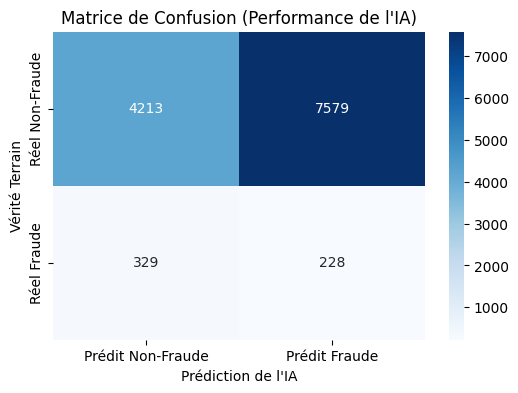


--- RAPPORT DE PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.93      0.36      0.52     11792
           1       0.03      0.41      0.05       557

    accuracy                           0.36     12349
   macro avg       0.48      0.38      0.29     12349
weighted avg       0.89      0.36      0.50     12349

AUC Score (Capacité de tri global) : 0.3162

--- IMPACT FINANCIER SIMULÉ ---
Fraudes correctement bloquées : 228
Clients honnêtes suspectés à tort : 7579
Gain net estimé pour l'assureur : -1219400 €


In [6]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger ton fichier de résultats
df = pd.read_csv('base_scoree_finale.csv')

# 2. Définir le seuil de décision
# L'IA donne une proba (ex: 0.89). Si > 0.5, on dit "C'est une fraude".
seuil = 0.5
df['PREDICTION_CLASSE'] = (df['SCORE_IA'] > seuil).astype(int)

# 3. Calculer la Matrice de Confusion
# C'est LE tableau le plus important de ton mémoire
conf_matrix = confusion_matrix(df['IS_FRAUD'], df['PREDICTION_CLASSE'])

# Affichage propre
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prédit Non-Fraude', 'Prédit Fraude'],
            yticklabels=['Réel Non-Fraude', 'Réel Fraude'])
plt.title('Matrice de Confusion (Performance de l\'IA)')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction de l\'IA')
plt.show()

# 4. Les Métriques Actuarielles
print("\n--- RAPPORT DE PERFORMANCE ---")
print(classification_report(df['IS_FRAUD'], df['PREDICTION_CLASSE']))

auc = roc_auc_score(df['IS_FRAUD'], df['SCORE_IA'])
print(f"AUC Score (Capacité de tri global) : {auc:.4f}")
# Si AUC = 0.5 -> Ton IA joue à pile ou face (Nul).
# Si AUC > 0.8 -> Ton IA est excellente.

# 5. Calcul Financier (Pour le Boss)
# Imaginons : Un sinistre moyen coûte 1500€. Une enquête inutile coûte 200€.
cout_moyen_sinistre = 1500
cout_enquete = 200

# Vrais Positifs (Fraudes arrêtées) : On économise le sinistre - le coût d'enquête
VP = conf_matrix[1, 1]
economie = VP * (cout_moyen_sinistre - cout_enquete)

# Faux Positifs (Clients honnêtes embêtés) : On perd juste le coût d'enquête
FP = conf_matrix[0, 1]
perte_inutile = FP * cout_enquete

gain_net = economie - perte_inutile

print(f"\n--- IMPACT FINANCIER SIMULÉ ---")
print(f"Fraudes correctement bloquées : {VP}")
print(f"Clients honnêtes suspectés à tort : {FP}")
print(f"Gain net estimé pour l'assureur : {gain_net} €")